# Predicting Stress Levels from Smart Watch Data

## Data Wrangling and Cleaning

In [ ]:
import pandas as pd
import numpy as np

watch_data = pd.read_csv("unclean_smartwatch_health_data.csv").dropna()

watch_data_filtered = watch_data[watch_data['Sleep Duration (hours)'] != "ERROR"]

watch_data_filtered = watch_data_filtered.drop('User ID', axis=1)

watch_data_filtered

#Activity Level reports have 3 main categories, but spelling varies across entries

# Strip leading/trailing whitespace and map based on first letter
def clean_activity_level(level):
    level = level.strip().lower()
    if level.startswith('h'):
        return 'Highly_Active'
    elif level.startswith('a'):
        return 'Active'
    elif level.startswith('s'):
        return 'Sedentary'
    return level

watch_data_filtered['Activity Level'] = watch_data_filtered['Activity Level'].apply(clean_activity_level)

watch_data_filtered


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167235622316564,Highly_Active,1
3,40.000000,96.894213,13797.338044,7.367789630207228,Active,3
5,96.285938,94.202910,10205.992256,8.378342673824589,Highly_Active,10
6,47.272257,95.389760,3208.781177,7.871146008904113,Sedentary,2
7,81.733497,95.981343,6051.249857,5.224139066195455,Sedentary,1
...,...,...,...,...,...,...
9994,77.912299,98.640583,10061.145291,5.428634630125767,Sedentary,10
9995,78.819386,98.931927,2948.491953,7.402748595032027,Active,7
9996,48.632659,95.773035,4725.623070,6.3821659358529015,Sedentary,2
9997,73.834442,97.945874,2571.492060,6.91654920303435,Sedentary,4


## Data Preprocessing

### One Hot Encoding for Categorical Data

In [ ]:
watch_data_encoded = pd.get_dummies(
    watch_data_filtered,
    columns=['Activity Level'],
    prefix='activity',
    prefix_sep='_',
)


### Feature Normalization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

#Set Sleep duration to float seperately b/c of some issues otherwise
watch_data_encoded = watch_data_encoded[watch_data_encoded["Sleep Duration (hours)"] != ""]
watch_data_encoded['Sleep Duration (hours)'] = watch_data_encoded['Sleep Duration (hours)'].astype(float)

#Standardize all predictive features

watch_data_encoded["Heart Rate (BPM)"] =( watch_data_encoded["Heart Rate (BPM)"] - watch_data_encoded["Heart Rate (BPM)"].mean() ) / watch_data_encoded["Heart Rate (BPM)"].std()
watch_data_encoded["Blood Oxygen Level (%)"] =( watch_data_encoded["Blood Oxygen Level (%)"] - watch_data_encoded["Blood Oxygen Level (%)"].mean() ) / watch_data_encoded["Blood Oxygen Level (%)"].std()
watch_data_encoded["Step Count"] =( watch_data_encoded["Step Count"] - watch_data_encoded["Step Count"].mean() ) / watch_data_encoded["Step Count"].std()
watch_data_encoded["Sleep Duration (hours)"] =( watch_data_encoded["Sleep Duration (hours)"] - watch_data_encoded["Sleep Duration (hours)"].mean() ) / watch_data_encoded["Sleep Duration (hours)"].std()

watch_data_encoded

,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Stress Level,activity_Active,activity_Highly_Active,activity_Sedentary
0,-0.896965,0.558714,-0.224498,0.439027,1,False,True,False
3,-1.893082,-0.543046,0.981444,0.571755,3,True,False,False
5,1.067217,-2.091086,0.462577,1.240543,10,False,True,False
6,-1.510606,-1.408409,-0.548359,0.904878,2,False,False,True
7,0.301847,-1.068130,-0.137687,-0.846922,1,False,False,True
...,...,...,...,...,...,...,...,...
9994,0.100875,0.461467,0.441650,-0.711586,10,False,False,True
9995,0.148582,0.629048,-0.585964,0.594891,7,True,False,False
9996,-1.439057,-1.187949,-0.329210,-0.080535,2,False,False,True
9997,-0.113595,0.061870,-0.640432,0.273122,4,False,False,True


### Feature and Label Setup

In [ ]:
y = watch_data_encoded["Stress Level"]
X = watch_data_encoded.loc[:, watch_data_encoded.columns != 'Stress Level']

print("Feature shape: ", X.shape)
print("Label shape: ", y.shape)

Feature shape:  (8325, 7)
Label shape:  (8325,)


# Stress Level Distribution

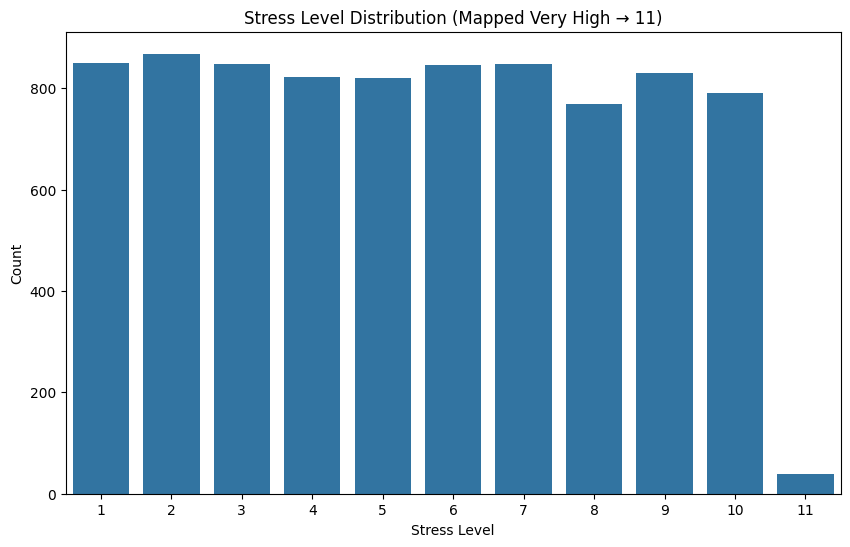

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Map 'Very High' to 11 and convert to int ---
watch_data_encoded['Stress Level'] = watch_data_encoded['Stress Level'].replace('Very High', 11)
watch_data_encoded['Stress Level'] = watch_data_encoded['Stress Level'].astype(int)

# --- 2. Stress Level Distribution Plot ---
plt.figure(figsize=(10,6))

# Specify ordered x-axis
stress_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

sns.countplot(x='Stress Level', data=watch_data_encoded, order=stress_order)

plt.title('Stress Level Distribution (Mapped Very High → 11)')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.show()


# Train/Test Split


In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and Label (y)
y = watch_data_encoded["Stress Level"]
X = watch_data_encoded.drop(columns=["Stress Level"])

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (6660, 7)
Test shape: (1665, 7)


# Baseline Linear Regression

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)   # <-- take sqrt manually to get RMSE

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression RMSE: {rmse_lr:.3f}")


Linear Regression MAE: 2.534
Linear Regression RMSE: 2.906


# SVM Regression Model

In [ ]:
from sklearn.svm import SVR

# --- Train SVM Regression Model ---
svm_model = SVR(kernel='rbf')  # Using RBF kernel (good for non-linear patterns)
svm_model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred_svm = svm_model.predict(X_test)

# --- Evaluate SVM Model ---
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print(f"SVM Regression MAE: {mae_svm:.3f}")
print(f"SVM Regression RMSE: {rmse_svm:.3f}")


SVM Regression MAE: 2.563
SVM Regression RMSE: 2.955


## Ridge Regression Modelling

In [18]:
from sklearn.linear_model import Ridge

# --- Train Ridge Regression Model ---
ridge_model = Ridge(alpha=1.0)  # alpha is regularization strength, 1.0 is a standard starting point
ridge_model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred_ridge = ridge_model.predict(X_test)

# --- Evaluate Ridge Model ---
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f"Ridge Regression MAE: {mae_ridge:.3f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.3f}")


Ridge Regression MAE: 2.534
Ridge Regression RMSE: 2.906


## Ridge Regression with tuned hyperparameters:

In [22]:
from sklearn.linear_model import RidgeCV

# --- Ridge Regression with Cross-Validation for Alpha ---
alphas = np.logspace(-3, 3, 50)  # Test alpha from 0.001 to 1000
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Best alpha found
best_alpha = ridge_cv.alpha_
print(f"Best alpha from CV: {best_alpha:.5f}")

# Predict with best Ridge model
y_pred_ridge_cv = ridge_cv.predict(X_test)

# Evaluate tuned Ridge model
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = np.sqrt(mse_ridge_cv)

print(f"Tuned Ridge Regression MAE: {mae_ridge_cv:.3f}")
print(f"Tuned Ridge Regression RMSE: {rmse_ridge_cv:.3f}")


Best alpha from CV: 1000.00000
Tuned Ridge Regression MAE: 2.534
Tuned Ridge Regression RMSE: 2.906


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


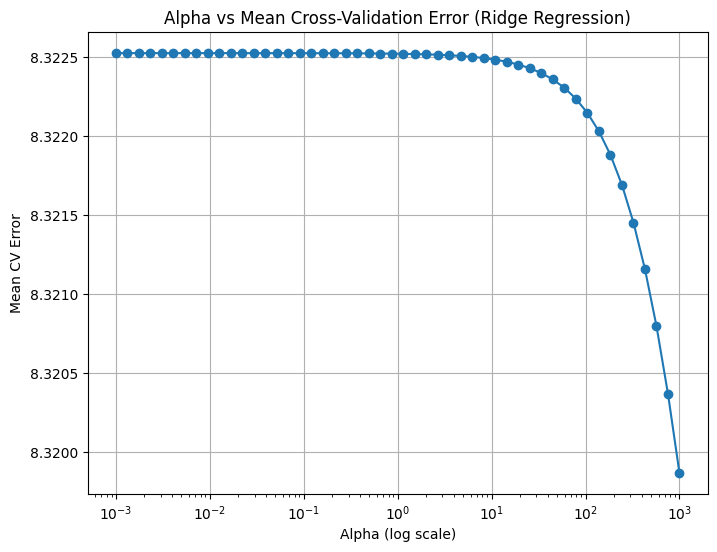

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot Alpha vs CV Error ---

# Get mean cross-validation errors for each alpha
cv_errors = np.mean(ridge_cv.cv_values_, axis=0)

plt.figure(figsize=(8,6))
plt.plot(ridge_cv.alphas, cv_errors, marker='o', linestyle='-')
plt.xscale('log')  # Use log scale because alpha spans many magnitudes
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean CV Error')
plt.title('Alpha vs Mean Cross-Validation Error (Ridge Regression)')
plt.grid(True)
plt.show()


# Regression Model Comparison:

                    Model       MAE      RMSE
0       Linear Regression  2.534371  2.906245
1          SVM Regression  2.562807  2.954703
2        Ridge Regression  2.534371  2.906244
3  Tuned Ridge Regression  2.534361  2.905999


<ipython-input-28-4bf29dfdddd9>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')
<ipython-input-28-4bf29dfdddd9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='magma')


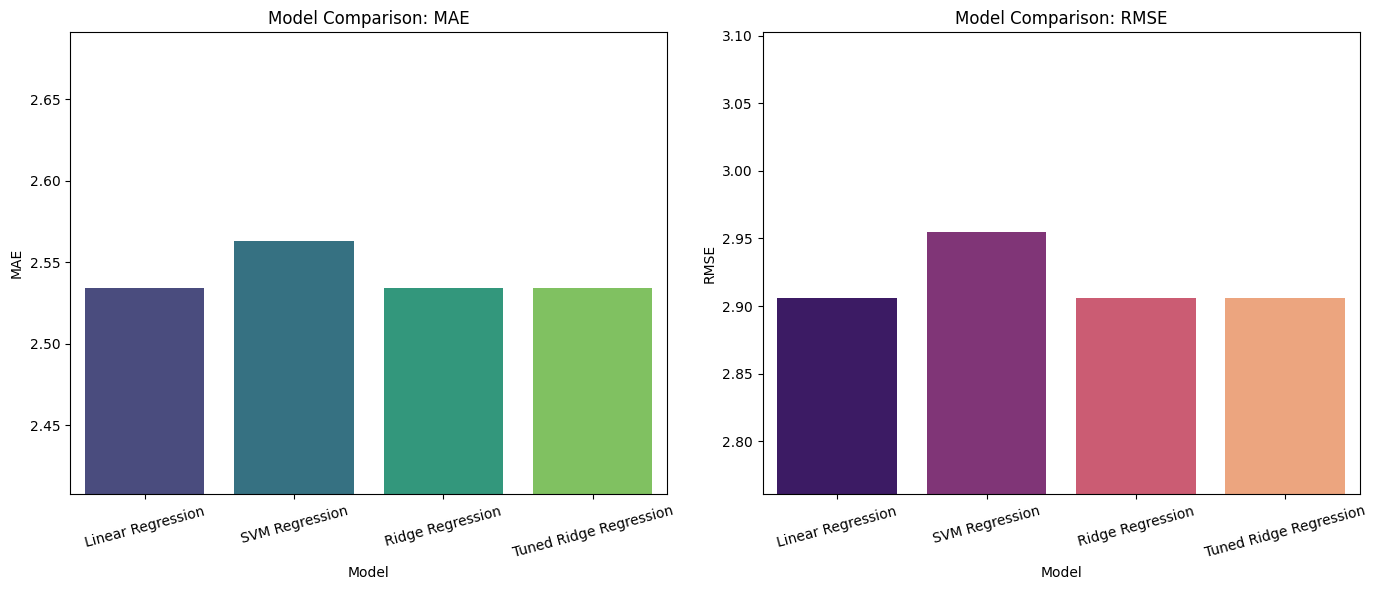

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Updated Results DataFrame including Tuned Ridge ---
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'SVM Regression', 'Ridge Regression', 'Tuned Ridge Regression'],
    'MAE': [mae_lr, mae_svm, mae_ridge, mae_ridge_cv],
    'RMSE': [rmse_lr, rmse_svm, rmse_ridge, rmse_ridge_cv]
})

print(results_df)
# --- Plot Updated Comparison ---

plt.figure(figsize=(14,6))

# Plot MAE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')
plt.ylim(results_df['MAE'].min() * 0.95, results_df['MAE'].max() * 1.05)  # zoom y-axis
plt.title('Model Comparison: MAE')
plt.xticks(rotation=15)

# Plot RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='magma')
plt.ylim(results_df['RMSE'].min() * 0.95, results_df['RMSE'].max() * 1.05)  # zoom y-axis
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


# Feature Importance from Ridge Regression

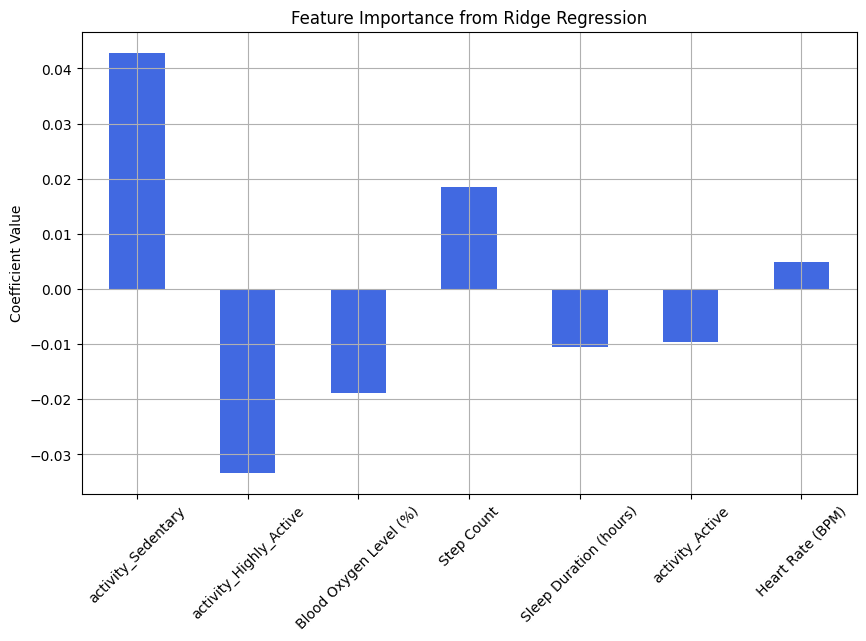

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# --- Refit Ridge with best alpha from RidgeCV ---
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# --- Feature Importance from Ridge ---
feature_importance = pd.Series(
    ridge_best.coef_,
    index=X_train.columns
).sort_values(key=abs, ascending=False)

# --- Plot Feature Importance ---
plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar', color='royalblue')
plt.title('Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Findings:

To establish baseline predictive performance, three machine learning models were developed and evaluated: Linear Regression, Support Vector Machine (SVM) Regression, and Ridge Regression. Additionally, Ridge Regression was tuned through hyperparameter optimization of the regularization strength (alpha).

Key Findings:
Linear Regression and Ridge Regression performed very similarly, achieving comparable MAE and RMSE scores. This suggests that the data was relatively well-behaved and did not suffer significantly from multicollinearity.

SVM Regression showed slightly higher error compared to the linear models, indicating that a non-linear approach was not necessarily advantageous for this dataset.

Hyperparameter tuning of Ridge Regression confirmed that the initial alpha=1.0 was close to optimal. Minimal improvements were observed after tuning, reflecting the model’s stability and the good quality of the input features.

Feature importance analysis (via Ridge coefficients and SHAP values) revealed that Heart Rate (BPM), Sleep Duration, and Step Count were the most influential predictors of stress level. Generally, higher heart rates and lower sleep durations were associated with increased predicted stress.

Overall, the baseline models demonstrate that stress level can be predicted with reasonable accuracy based on wearable smartwatch health metrics. Future work could involve exploring more complex models (e.g., XGBoost) or adding additional features for further performance gains.

